In [1]:
import gizmo_analysis as gizmo
import utilities as ut
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import optimize
import pandas as pd
import glob
import math
import os

In [2]:
def select_neutral(temperatures, radii):

    #WNM + CNM
    select_phases = np.all([(radii < 0.1*r_vir), (temperatures < 10**4)], axis = 0)

    return select_phases

In [3]:
def num_PDF(values, weights, left, right, bin_size):
    
    bins = np.arange(left, right, bin_size)
    heights, edges = np.histogram(values, bins, weights = weights)
    centers = 0.5*(edges[1:] + edges[:-1])
    heights = heights/bin_size

    return centers, heights

In [4]:
def fit_error(y, f):
    return np.sum((y-f)**2)

In [5]:
def fit_func_1(Z, A, sigma):
    
    P = (A/np.sqrt(2*np.pi*sigma**2))*np.exp(-Z**2/(2*sigma**2))
    
    return P

In [6]:
def fit_func_2(Z, B, alpha):
    
    P = B*np.exp(-alpha*Z)
    
    return P

In [7]:
def fit_PDF(centers, heights):
    
    # Information about the peak in the numerical PDF
    peak_height = np.max(heights)
    peak_ind = np.where(heights == peak_height)[0][0]
    
    # mu is where the numerical PDF peaks
    mu = centers[peak_ind]
 
    # Recentering so that peak is at z = 0
    del_centers = centers - mu
    gauss_centers = del_centers[0:peak_ind+1]
    gauss_heights = heights[0:peak_ind+1]
                
    fit = np.zeros(len(centers))
    fit_err = np.inf
    fit_params = np.zeros(5)
    
    for i in range(0, len(fit_params)):
        fit_params[i] = float('nan')
    
    try:
        
        # Estimating sigma using FWHM
        sigma = 0

        for i in range(0, len(gauss_centers)):
            if(heights[i] >= peak_height/2):
                sigma = (-gauss_centers[i])/np.sqrt(2*np.log(2))
                break

        # Estimating A accordingly, by using the peak height
        A = np.sqrt(2*np.pi*sigma**2)*peak_height

        # First fit a Gaussian

        guess_gauss_params = np.array([A, sigma])
        
        gauss_bounds = ([0, 0], [np.max(heights), np.max(np.abs(del_centers))])

        fit_gauss_params, fit_gauss_covar = optimize.curve_fit(fit_func_1, gauss_centers, gauss_heights,
                                                               p0 = guess_gauss_params, 
                                                               bounds = gauss_bounds, method = 'trf')

                
        fit_params[0] = fit_gauss_params[0]
        fit_params[1] = mu
        fit_params[2] = fit_gauss_params[1]

        fit = fit_func_1(del_centers, *fit_gauss_params)
        fit_err = fit_error(heights, fit)

        # See if an exponential decay tail exists and is a better fit

        for i in range(peak_ind, len(centers)):

            try:

                v_T = centers[i]

                exp_centers = del_centers[i:] - del_centers[i]

                exp_heights = heights[i:]
                init_height = exp_heights[0]

                # Estimating alpha using half-life decay
                alpha = 0

                for j in range(0, len(exp_centers)):
                    if(exp_heights[j] <= init_height/2):
                        alpha = np.log(2)/(exp_centers[j])
                        break

                B = (fit_params[0]*np.exp(alpha*v_T))/np.sqrt(2*np.pi*fit_params[2]**2)*np.exp(-(v_T-mu)**2/(2*fit_params[2]**2))

                guess_exp_params = np.array([B, alpha])
                
                exp_bounds = ([0, 0], [np.max(heights), np.inf])

                fit_exp_params, fit_exp_covar = optimize.curve_fit(fit_func_2, exp_centers, exp_heights,
                                                                   p0 = guess_exp_params, 
                                                                   bounds = exp_bounds, method = 'trf')

                gauss_fit = fit_func_1(del_centers[:i], *fit_gauss_params)
                exp_fit = fit_func_2(exp_centers, *fit_exp_params)
                curr_fit = np.concatenate([gauss_fit, exp_fit])
                curr_err = fit_error(heights, curr_fit)

                if(curr_err < fit_err):
                    fit = curr_fit
                    fit_err = curr_err
                    fit_params[3] = fit_exp_params[1]
                    fit_params[4] = v_T

            except:
                continue
                
    except:
        
        pass
    
    return fit, fit_params

In [8]:
# Specifying simulation directory and the directory to save results in

wdir = str(input('Enter simulation directory path: '))

# Creating a snapshot for temporal analysis
sdir = wdir + 'temporal_analysis/sampling_plots/'

if not os.path.exists(sdir):
    os.makedirs(sdir)

Enter simulation directory path: /Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/


In [9]:
snap_index = 600
redshift = 0.
m = 'fe'

In [10]:
part = gizmo.io.Read.read_snapshots(['star','gas', 'dark'], 'index', snap_index, assign_hosts_rotation = True, 
    simulation_directory = wdir)

# Getting halo properties
halo_properties = ut.particle.get_halo_properties(part, 'all')

# Halo mass
halo_mass = halo_properties['mass']

# Virial radius
r_vir = halo_properties['radius']

# Finding some important spatial distributions
radii = part['gas'].prop('host.distance.total')
temperatures = part['gas'].prop('temperature')
masses = part['gas'].prop('mass')

# Details for the neutral phase
select_ind = select_neutral(temperatures, radii)

# Grid distribution of masses and volumes in neutral medium gas
mass_dist = masses[select_ind]

abundances = part['gas'].prop('metallicity.' + m)[select_ind]


# in utilities.simulation.Snapshot():
* reading:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 260408 particles
    dark2     (id = 2): 2281573 particles
    gas       (id = 0): 259203 particles
    star      (id = 4): 1205 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas', 'dark']
* reading particles from:
    Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/snapshot_600.hdf5

! cannot find MUSIC config file:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assumin

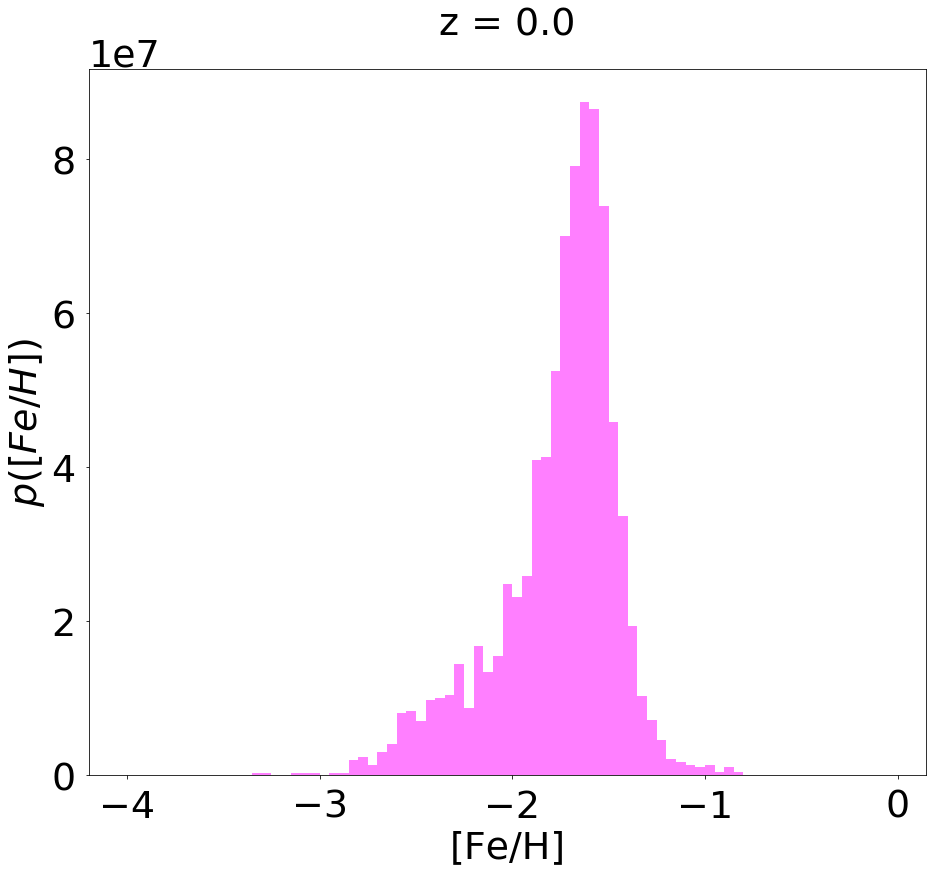

In [14]:
# Plot histogram

fig, ax = plt.subplots(figsize = (15, 13))

left = np.floor(np.min(abundances))
right = np.ceil(np.max(abundances))

ax.hist(abundances, bins = np.arange(left, right, 0.05), weights = mass_dist/0.05, color = 'magenta', alpha = 0.5)

ax.set_xlabel('[{}/H]'.format(m.title()), fontsize = 38)
ax.set_ylabel(r'$p \left( \left[ {}/H \right] \right)$'.format(m.title()), fontsize = 38)
ax.set_title('z = {}'.format(str(round(redshift, 2))), y = 1.04, fontsize = 38)

ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(38)

plt.savefig(sdir + '1-hist')

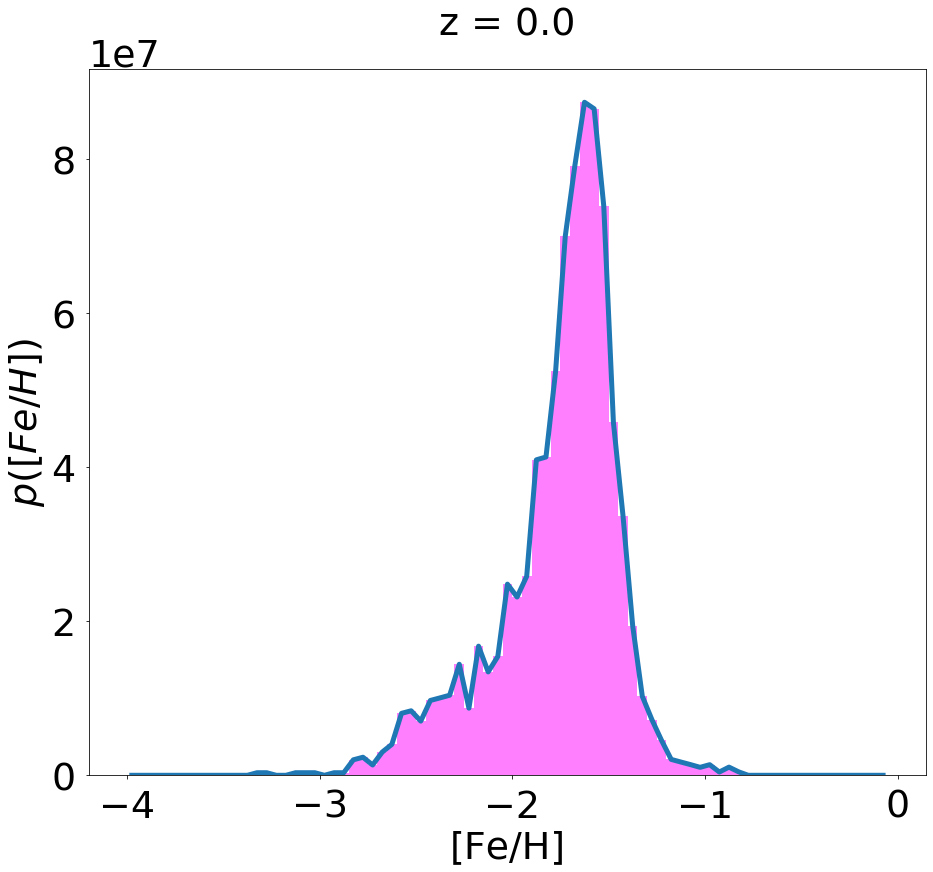

In [15]:
# Plot histogram

fig, ax = plt.subplots(figsize = (15, 13))

left = np.floor(np.min(abundances))
right = np.ceil(np.max(abundances))

ax.hist(abundances, bins = np.arange(left, right, 0.05), weights = mass_dist/0.05, color = 'magenta', alpha = 0.5)

bin_size = 0.05
centers, heights = num_PDF(abundances, mass_dist, left, right, bin_size)
ax.plot(centers, heights, lw = 5)

ax.set_xlabel('[{}/H]'.format(m.title()), fontsize = 38)
ax.set_ylabel(r'$p \left( \left[ {}/H \right] \right)$'.format(m.title()), fontsize = 38)
ax.set_title('z = {}'.format(str(round(redshift, 2))), y = 1.04, fontsize = 38)

ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(38)

plt.savefig(sdir + '2-num_PDF')

/Users/thepoetoftwilight/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in double_scalars
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:426: RuntimeWarning: invalid value encountered in subtract
  upper_dist = ub - x
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:432: RuntimeWarning: invalid value encountered in less_equal
  (lower_dist <= np.minimum(upper_dist, lower_threshold)))
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:436: RuntimeWarning: invalid value encountered in less_equal
  (upper_dist <= np.minimum(lower_dist, upper_threshold)))
/Users/thepoetoftwilight/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


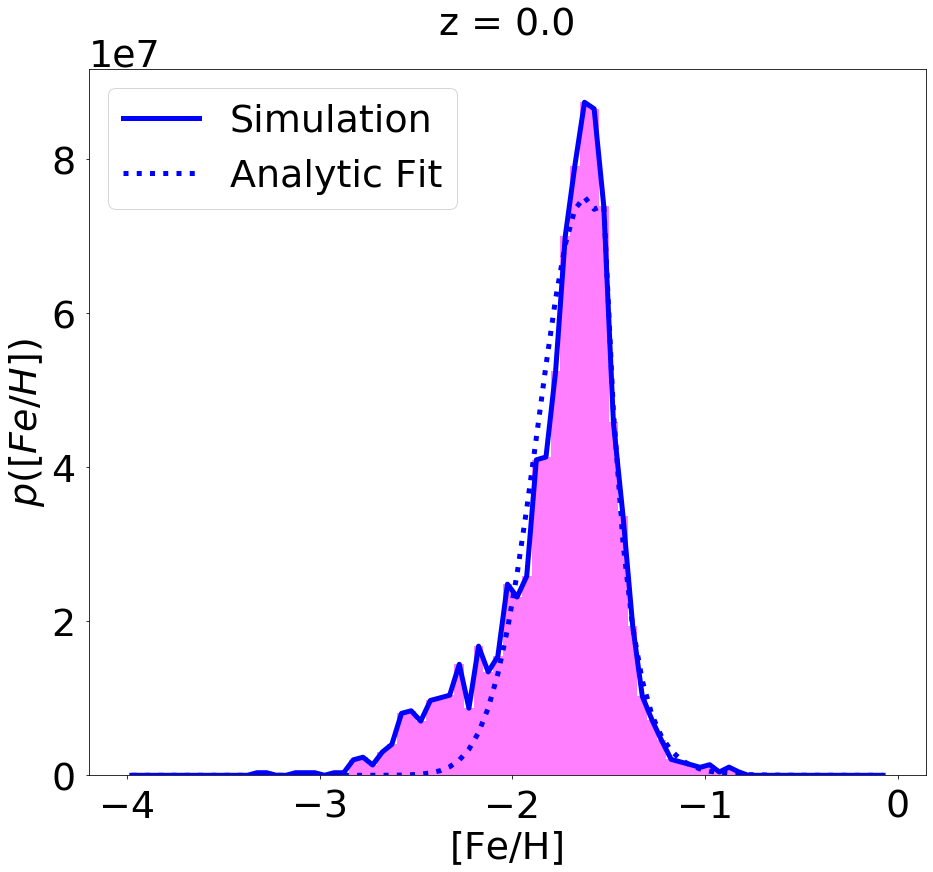

In [17]:
# Plot histogram

fig, ax = plt.subplots(figsize = (15, 13))

left = np.floor(np.min(abundances))
right = np.ceil(np.max(abundances))

ax.hist(abundances, bins = np.arange(left, right, 0.05), weights = mass_dist/0.05, color = 'magenta', alpha = 0.5)

bin_size = 0.05
centers, heights = num_PDF(abundances, mass_dist, left, right, bin_size)
ax.plot(centers, heights, lw = 5, color = 'blue', label = 'Simulation')

mass_norm = np.max(heights)
heights /= mass_norm

# Compute the fitted PDF

fit, fit_params = fit_PDF(centers, heights)

# Rescaling range to achieve desired normalization

heights *= mass_norm
fit *= mass_norm
fit_params[0] *= mass_norm

ax.plot(centers, fit, linestyle = ':', lw = 5, color = 'blue', label = 'Analytic Fit')

ax.set_xlabel('[{}/H]'.format(m.title()), fontsize = 38)
ax.set_ylabel(r'$p \left( \left[ {}/H \right] \right)$'.format(m.title()), fontsize = 38)
ax.set_title('z = {}'.format(str(round(redshift, 2))), y = 1.04, fontsize = 38)

ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(38)
ax.legend(prop={'size': 38}, loc = 'upper left')

plt.savefig(sdir + '3-fit_PDF')